In [35]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from keras.layers import Input, Dense, Lambda, InputLayer, concatenate
from keras.models import Model, Sequential
from keras import backend as K
from keras import metrics
from keras.datasets import mnist
from keras.utils import to_categorical

# Task 1

In [36]:
# load the data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
# scale the data
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

In [67]:
# matrix into vector
x_train = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

In [68]:
np.prod(x_train.shape[1:])

784

In [69]:
x_train.shape[1]

784

In [70]:
original_dim = x_train.shape[1]

## a)

From the lecture we know that ELBO equals

$$ELBO = \mathbb{E}_q \log p(x|z) - KL(q(z|x)||p(z)).$$

Assume that we already know the parameters of the encoder 

$$\mathbb{E}_q \log p(x|z) = \mathbb{E}_{\varepsilon} \log p(x|z_{\phi}(\varepsilon, x))$$

Below: 

 - `x` - observed vector of pixels (0 and 1)
 - `x_decoded` - $p(1|z_{\phi}(\varepsilon, x)) = p(1|\mu_{\phi}(x) + \Sigma_{\phi}(x)^{1/2}\varepsilon)$, where $\varepsilon$ was generated according to $\mathcal{N}(0, 1)$ - the aposteriori probability of the pixel being $1$ after reparametrization trick
 - $\Sigma_{\phi}(x) = \textrm{diag}(\sigma_{\phi, 1}^2(x), \sigma_{\phi, 2}^2, \ldots, \sigma_{\phi, K}^2)$
 - `z_mean` - $\mu_{\phi}(x) = (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x))$
 - `z_log_var` - $(\log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x))$

 - $q(z|x) = \mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

Input: `x, x_decoded, z_mean, z_log_var`

Output: ELBO

In [71]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):
    pass
    # loss_term = bernoulli loss between true x and predicted x_decoded

    # KL_term = KL divergence between normal with params z_mean, z_log_var and standard multivariate normal

    # return tf.reduce_mean(loss_term - KL_term)

In [72]:
@tf.function
def elbo_vae(x, x_decoded, z_mean, z_log_var):

    loss_term = tf.reduce_sum(x * tf.math.log(x_decoded + 1e-19) + (1 - x) * tf.math.log(1 - x_decoded + 1e-19), 1)

    KL_term =  0.5 * tf.reduce_sum(-z_log_var + tf.exp(z_log_var) + tf.square(z_mean) - 1, 1)

    return tf.reduce_mean(loss_term - KL_term)

## b)

Next we need to get a sample from $q(z|x)$. We will use a reparametrization trick.

Input: `z_mean, z_log_var`

Output: $\mathcal{N}(\mu_{\phi}(x), \Sigma_{\phi}(x))$

In [73]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        # epsilon = sample from standard normal distribution (sample batch observation from dim dimensional normal distribution)
        return # transform epsilon so it becomes from the normal distribution with params z_mean, z_log_var

In [74]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.random.normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

## c)

A part of the model that takes input and returns a vector:

$$ (\mu_{\phi, 1}(x), \mu_{\phi, 2}(x), \ldots, \mu_{\phi, K}(x), \log\sigma_{\phi, 1}^2(x), \log\sigma_{\phi, 2}^2(x), \ldots, \log\sigma_{\phi, K}^2(x)) $$

Due to technical reason we will return the above vector and sampled values of $z$ as the output of the encoder (and not as a separate layer).

In [79]:
latent_dim = 10
original_dim = 784

encoder_inputs = keras.Input(shape=(original_dim,))
x = Dense(256, activation='relu')(encoder_inputs)
x = Dense(256, activation='tanh')(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                  ┃ Output Shape              ┃         Param # ┃ Connected to               ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_17 (InputLayer)   │ (None, 784)               │               0 │ -                          │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_23 (Dense)              │ (None, 256)               │         200,960 │ input_layer_17[0][0]       │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ dense_24 (Dense)              │ (None, 256)               │          65,792 │ dense_23[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_mean (Dense)                │ (None, 10)                │           2,570 │ dense_24[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ z_log_var (Dense)             │ (None, 10)                │           2,570 │ dense_24[0][0]             │
├───────────────────────────────┼───────────────────────────┼─────────────────┼────────────────────────────┤
│ sampling_7 (Sampling)         │ (None, 10)                │               0 │ z_mean[0][0],              │
│                               │                           │                 │ z_log_var[0][0]            │
└───────────────────────────────┴───────────────────────────┴─────────────────┴────────────────────────────┘

 Total params: 271,892 (1.04 MB)

 Trainable params: 271,892 (1.04 MB)

 Non-trainable params: 0 (0.00 B)

In [81]:
# number of parameters:
(784 + 1)*256, (256 + 1)*256, (256 + 1)*latent_dim

(200960, 65792, 2570)

## d)

In [82]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = Dense(256, activation='relu')(latent_inputs)
x = Dense(256, activation='tanh')(x)
decoder_outputs = Dense(original_dim, activation='sigmoid')(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_18 (InputLayer)          │ (None, 10)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_25 (Dense)                     │ (None, 256)                 │           2,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_26 (Dense)                     │ (None, 256)                 │          65,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_27 (Dense)                     │ (None, 784)                 │         201,488 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 270,096 (1.03 MB)

 Trainable params: 270,096 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

## e)

In [83]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super().__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)

            total_loss = -elbo_vae(data, reconstruction, z_mean, z_log_var)           

        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)

        return {"loss": self.total_loss_tracker.result()}        

In [84]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(x_train, epochs=10, batch_size=128)

Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - loss: 223.2591 - total_loss: 181.1638
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 139.6312 - total_loss: 135.5246
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 126.1836 - total_loss: 124.1770
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 119.5844 - total_loss: 118.7574
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 8s 16ms/step - loss: 115.8865 - total_loss: 115.8464
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 113.7812 - total_loss: 113.7154
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 112.1804 - total_loss: 112.1842
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 110.9131 - total_loss: 110.8833
Epoch 9/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 109.7000 - total_loss: 109.8800
Epoch 10/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 7s 16ms/step - loss: 109.1782 - total_loss: 109.0041


## f)

In [85]:
# representation in the latent space of observations from test ds
z_test_pred = encoder.predict(x_test)

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [86]:
z_test_pred[0][0]

array([ 1.5261855 , -0.9171091 ,  0.27564391,  1.4156194 ,  0.6475782 ,
        1.1259224 ,  0.43431896,  1.2728206 , -0.3544385 , -1.878802  ],
      dtype=float32)

In [87]:
# in a list z_test_pred indeces mean: 0-vector of means, 1-vector of variances, 2-values in the latent space
# this is a prediction
test_pred = decoder.predict(z_test_pred[0])#- we take a vector from the latent space and transform it to be again a picture

313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step


In [88]:
import matplotlib.pyplot as plt
import seaborn as sns

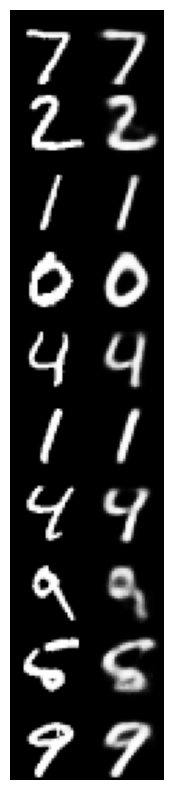

In [89]:
n = 10  # figure with 10 x 2 digits
digit_size = (np.sqrt(original_dim)).astype('int')
fig = plt.figure(figsize=(10, 10))
figure = np.zeros((digit_size * n, digit_size * 2))
decoded = test_pred

for i in range(10):
    figure[i * digit_size: (i + 1) * digit_size, :digit_size] = x_test[i, :].reshape(digit_size, digit_size)
    figure[i * digit_size: (i + 1) * digit_size, digit_size:] = decoded[i, :].reshape(digit_size, digit_size)
    
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.show()


## g)

In [90]:
z_test_pred = np.array(z_test_pred)

In [91]:
from sklearn.manifold import TSNE

In [92]:
tsne = TSNE(n_components=2)

In [93]:
z_test_pred_tsne = tsne.fit_transform(z_test_pred[0])

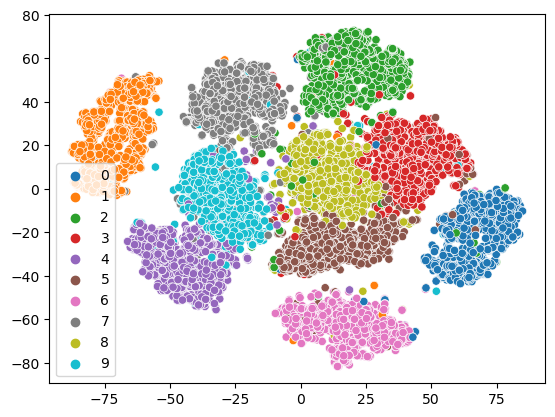

In [94]:
N=10000
sns.scatterplot(x=z_test_pred_tsne[:N,0], y=z_test_pred_tsne[:N,1], hue=y_test[:N], palette=sns.color_palette("tab10"))
plt.show()

<h1>h)</h1>

In [95]:
pic1 = np.random.normal(size=10)

In [96]:
pic1

array([-1.05924853,  0.90052376,  0.56109507, -0.78768609, -0.27971187,
       -1.24087083, -0.39551216, -0.39980078,  0.16409551,  0.69687848])

In [97]:
pic1 = decoder.predict(np.array([pic1]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step


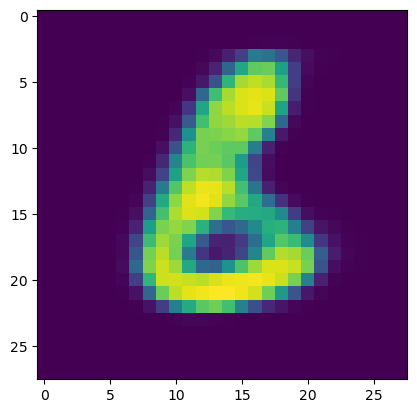

In [98]:
plt.imshow(pic1[0].reshape(28, 28))

<h1>Task 3</h1>


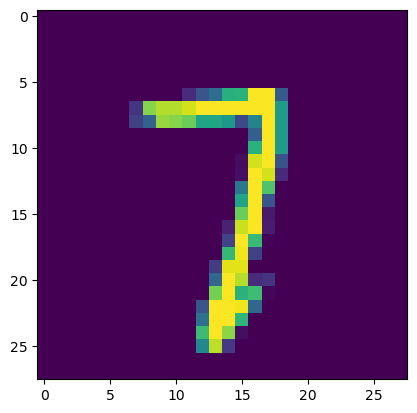

In [113]:
plt.imshow(x_test[234].reshape(28, 28))

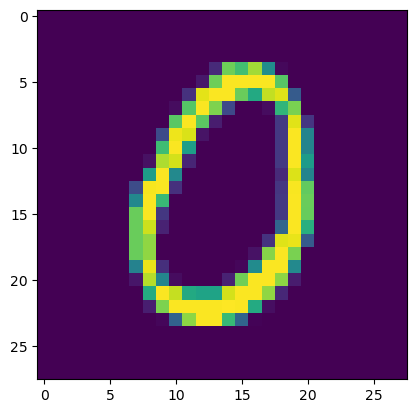

In [115]:
plt.imshow(x_test[485].reshape(28, 28))

In [124]:
pic1 = x_test[234]
pic2 = x_test[485]

In [125]:
pic1 = encoder.predict(np.array([pic1]))
pic2 = encoder.predict(np.array([pic2]))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


In [126]:
pic1[0]

array([[-0.31112617, -0.56679887, -0.67045134,  0.81836456, -0.23256502,
         1.2585737 ,  0.03262018,  1.6937276 ,  0.8223078 ,  0.02945093]],
      dtype=float32)

In [127]:
pic2[0]

array([[ 0.07951534,  0.5723663 , -0.6252876 , -0.00666587, -0.09803012,
         2.301415  , -0.8215106 , -0.8540508 , -0.28025848, -0.85032064]],
      dtype=float32)

In [128]:
t = (pic2[0] - pic1[0])/10 

In [129]:
pic1[0] + t * 10

array([[ 0.07951534,  0.5723663 , -0.6252876 , -0.00666589, -0.09803012,
         2.301415  , -0.8215107 , -0.854051  , -0.28025842, -0.85032064]],
      dtype=float32)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 65ms/step


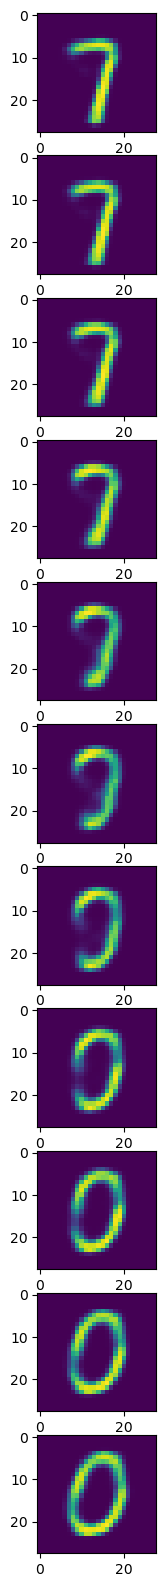

In [130]:
fig, axes = plt.subplots(nrows=11, ncols=1, figsize=(20, 20))


for i in range(11):
    pic = pic1[0] + t * i
    decoded_pic = decoder.predict(np.array(pic))
    axes[i].imshow(decoded_pic.reshape(28,28))